# Libraries


In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA


# Explore Data and Distributions of Features

In [51]:
#data
votecensus_2020 = pd.read_csv('../data/clean/votemargins_census_joined_2020_subset_largemargins.csv') # relative path
votecensus_2020.head()

,unique_id,year,state_po,county_name,votemargin_DR,proportion_explained_by_DR,delta_2012_16,delta_2016_20,abs_delta_2012_16,abs_delta_2016_20,margin_2012,margin_2016,margin_2020,totalvotes,DP2_education_bachelormin_PE,DP2_marital_male_nevermarried_PE,DP2_foreign_born_PE,DP3_employment_unemp_PE,DP3_median_income_norm
0,2020_01019,2020,AL,CHEROKEE,-72.8,99.2,-14.0,-3.8,14.0,3.8,-55.0,-69.0,-72.8,12301,12.9,23.1,1.9,2.0,16.2
1,2020_01037,2020,AL,COOSA,-33.5,99.1,-14.2,-3.0,14.2,3.0,-16.3,-30.4,-33.5,5479,11.6,33.9,0.5,1.2,17.0
2,2020_01059,2020,AL,FRANKLIN,-65.9,99.1,-19.9,-5.5,19.9,5.5,-40.5,-60.4,-65.9,12578,15.0,32.1,9.1,2.7,15.1
3,2020_01071,2020,AL,JACKSON,-67.5,98.9,-20.1,-5.5,20.1,5.5,-41.9,-61.9,-67.5,23636,16.2,25.4,1.5,2.6,16.3
4,2020_01075,2020,AL,LAMAR,-72.2,99.4,-15.5,-3.5,15.5,3.5,-53.2,-68.7,-72.2,7193,11.3,25.0,0.9,2.6,16.3


In [53]:
votecensus_2020.drop('totalvotes', axis=1, inplace=True)
votecensus_2020_clustered = votecensus_2020.copy()
votecensus_2020_clustered.shape

(680, 18)

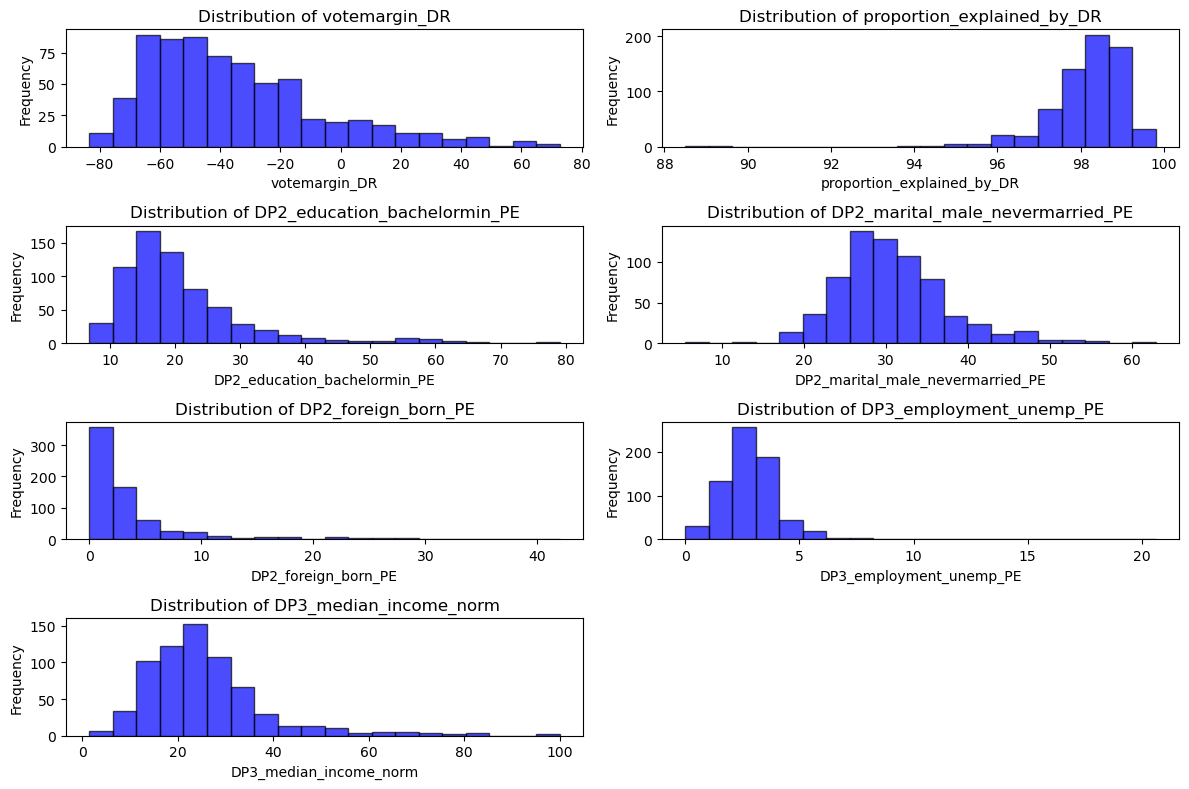

In [55]:
# state our columns
columns = ['votemargin_DR', 
           'proportion_explained_by_DR', 
           'DP2_education_bachelormin_PE', 
           'DP2_marital_male_nevermarried_PE', 
           'DP2_foreign_born_PE',
          'DP3_employment_unemp_PE',
          'DP3_median_income_norm']

# set up the matplotlib histogram
plt.figure(figsize=(12, 8))

#looping over our variable (columns) to create histograms
for i, column in enumerate(columns, 1):
    plt.subplot(4, 2, i)  # create a 4x2 grid for 7 plots
    plt.hist(votecensus_2020[column], 
             bins=20, 
             color='blue', 
             edgecolor='black', 
             alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# layout and print
plt.tight_layout()
plt.show()

In [195]:
# given that our features are not on the same scale (votemargin, specifically)
# we are going to standardize!

# but given the skew we see in FOREIGN BORN and  PROPORTION EXPLAINED BY DR
# we may have to further transform our data

In [57]:
no_id_cols = votecensus_2020.drop(columns=['unique_id', 'year', 'state_po', 'county_name'])  # Drop ID column for preprocessing
features = no_id_cols.drop(columns=['abs_delta_2012_16', 'abs_delta_2016_20', 'margin_2012', 'margin_2016', 'margin_2020']) # drop non-clustering columns
no_id_cols.columns

Index(['votemargin_DR', 'proportion_explained_by_DR', 'delta_2012_16',
       'delta_2016_20', 'abs_delta_2012_16', 'abs_delta_2016_20',
       'margin_2012', 'margin_2016', 'margin_2020',
       'DP2_education_bachelormin_PE', 'DP2_marital_male_nevermarried_PE',
       'DP2_foreign_born_PE', 'DP3_employment_unemp_PE',
       'DP3_median_income_norm'],
      dtype='object')

In [59]:
features.columns

Index(['votemargin_DR', 'proportion_explained_by_DR', 'delta_2012_16',
       'delta_2016_20', 'DP2_education_bachelormin_PE',
       'DP2_marital_male_nevermarried_PE', 'DP2_foreign_born_PE',
       'DP3_employment_unemp_PE', 'DP3_median_income_norm'],
      dtype='object')

# YEO-Johnson Transformation (Alternative to Standardization)

In [61]:

#Yeo-Johnson Transformation (handles zero and negative values):
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
features_yeo = pt.fit_transform(features)
features_yeo_df = pd.DataFrame(features_yeo, columns=features.columns)

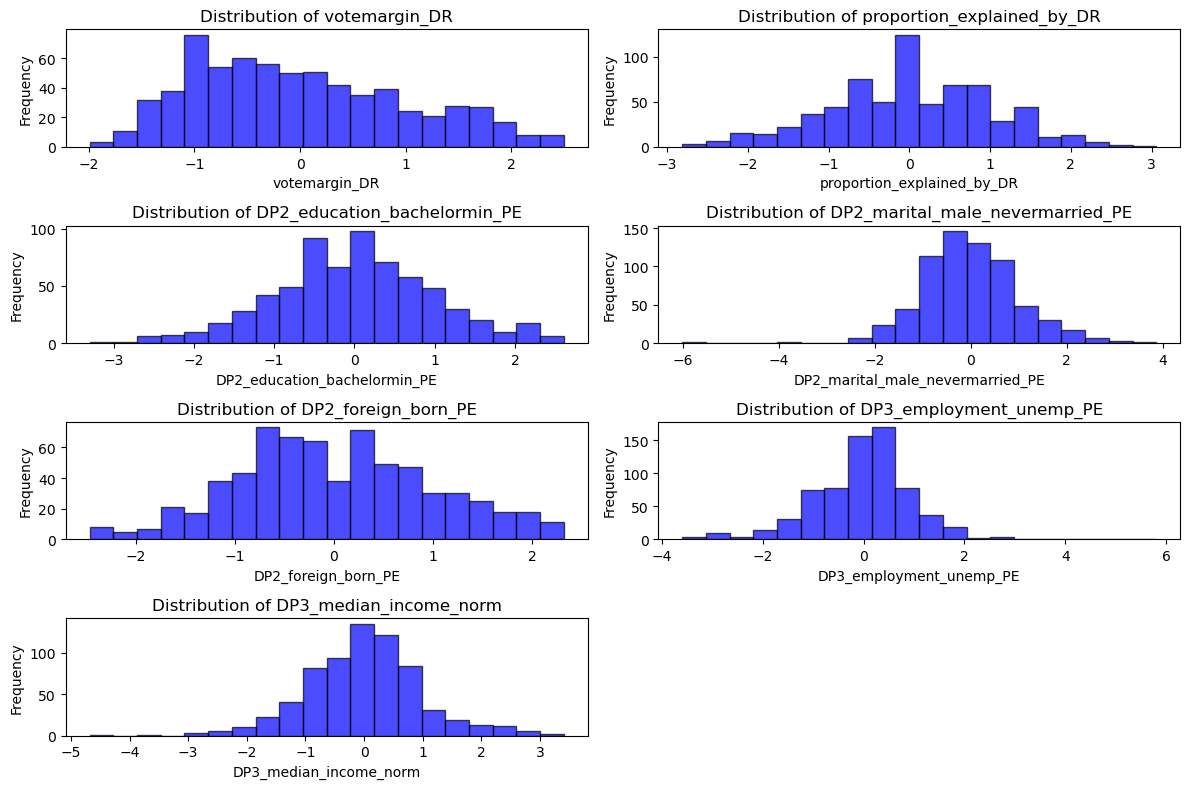

In [29]:
# state our columns
columns = ['votemargin_DR', 
           'proportion_explained_by_DR', 
           'DP2_education_bachelormin_PE', 
           'DP2_marital_male_nevermarried_PE', 
           'DP2_foreign_born_PE',
          'DP3_employment_unemp_PE',
          'DP3_median_income_norm']

# set up the matplotlib histogram
plt.figure(figsize=(12, 8))

#looping over our variable (columns) to create histograms
for i, column in enumerate(columns, 1):
    plt.subplot(4, 2, i)  # create a 4x2 grid for 7 plots
    plt.hist(features_yeo_df[column], 
             bins=20, 
             color='blue', 
             edgecolor='black', 
             alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

# layout and print
plt.tight_layout()
plt.show()

# KMEANS

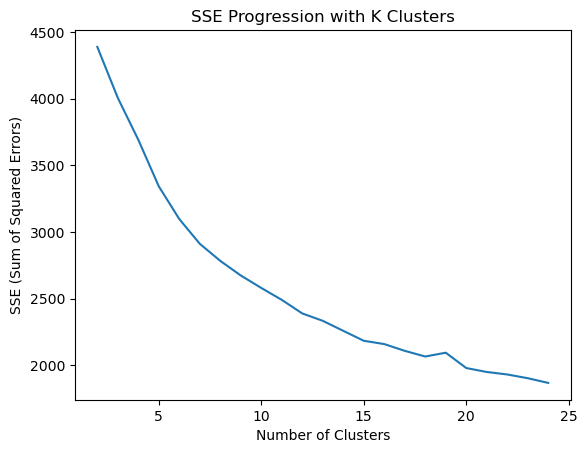

In [31]:
# inertia is our added SSEs, so lets find it for each k
# forloop over range 2-20
inertia = [KMeans(n_clusters=i).fit(features_yeo_df).inertia_ for i in range(2,25)]

# plot into elbow plot
plt.plot(range(2,25), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('SSE Progression with K Clusters')
plt.show()

In [33]:

# Iterate through different values of k
for k in range(2, 25):
    # Fit the KMeans model
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(features_yeo_df)
    
    # Compute silhouette score
    score = silhouette_score(features_yeo_df, labels)
    
    # Count the number of observations in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Print results
    print(f"K = {k}")
    print(f"Silhouette Score: {score:.4f}")
    print("Cluster Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"  Cluster {label}: {count} observations")
    print("-" * 50)


K = 2
Silhouette Score: 0.2839
Cluster Distribution:
  Cluster 0: 211 observations
  Cluster 1: 469 observations
--------------------------------------------------
K = 3
Silhouette Score: 0.1635
Cluster Distribution:
  Cluster 0: 221 observations
  Cluster 1: 284 observations
  Cluster 2: 175 observations
--------------------------------------------------
K = 4
Silhouette Score: 0.1599
Cluster Distribution:
  Cluster 0: 176 observations
  Cluster 1: 252 observations
  Cluster 2: 121 observations
  Cluster 3: 131 observations
--------------------------------------------------
K = 5
Silhouette Score: 0.1497
Cluster Distribution:
  Cluster 0: 212 observations
  Cluster 1: 213 observations
  Cluster 2: 66 observations
  Cluster 3: 35 observations
  Cluster 4: 154 observations
--------------------------------------------------
K = 6
Silhouette Score: 0.1499
Cluster Distribution:
  Cluster 0: 169 observations
  Cluster 1: 187 observations
  Cluster 2: 67 observations
  Cluster 3: 25 observat

In [35]:
# seems like 10 is a good place to stop, even though silhouette drops pretty badly from k = 3, 4
k = 10
model = KMeans(n_clusters=k, random_state=42)
kmeans_labels = model.fit_predict(features_yeo_df)

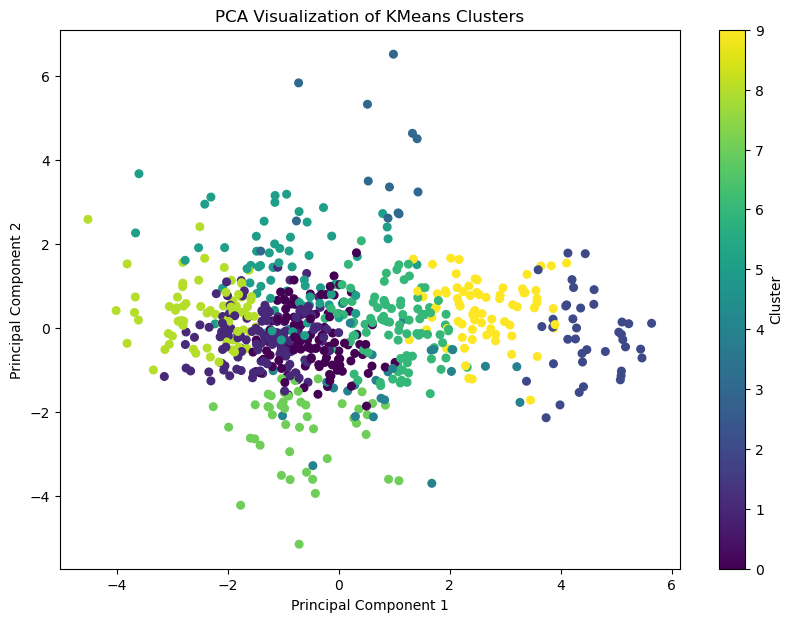

In [37]:

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_yeo_df)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 7))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30)
plt.colorbar(label='Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of KMeans Clusters')
plt.show()

# DBSCAN

In [109]:
for eps_val in [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]:  # Test multiple values
    dbscan = DBSCAN(eps=eps_val, min_samples=5)
    dbscan_labels = dbscan.fit_predict(features_yeo_df)
    print(f"eps={eps_val}, Number of Clusters: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}, Noise Points: {np.sum(dbscan_labels == -1)}")

eps=0.5, Number of Clusters: 0, Noise Points: 680
eps=0.6, Number of Clusters: 0, Noise Points: 680
eps=0.7, Number of Clusters: 0, Noise Points: 680
eps=0.8, Number of Clusters: 0, Noise Points: 680
eps=0.9, Number of Clusters: 4, Noise Points: 645
eps=1, Number of Clusters: 10, Noise Points: 554
eps=1.1, Number of Clusters: 10, Noise Points: 433
eps=1.2, Number of Clusters: 5, Noise Points: 332
eps=1.3, Number of Clusters: 2, Noise Points: 269
eps=1.4, Number of Clusters: 2, Noise Points: 210
eps=1.5, Number of Clusters: 1, Noise Points: 168
eps=1.6, Number of Clusters: 1, Noise Points: 142
eps=1.7, Number of Clusters: 2, Noise Points: 106
eps=1.8, Number of Clusters: 4, Noise Points: 69
eps=1.9, Number of Clusters: 2, Noise Points: 57
eps=2, Number of Clusters: 1, Noise Points: 51


In [111]:
# seems like 1.8 is a good eps to set
eps_val = 1.8
dbscan = DBSCAN(eps=eps_val, min_samples=5)  # Adjust min_samples if needed
dbscan_labels = dbscan.fit_predict(features_yeo_df)

# Check the cluster labels
print("Cluster Labels:", set(dbscan_labels))
noise_percentage = np.sum(dbscan_labels == -1) / len(dbscan_labels) * 100
print(f"Noise Percentage: {noise_percentage:.2f}%")


# looks like 9.26% noise for 680 obvs total, which means
#680*0.0926

Cluster Labels: {0, 1, 2, 3, -1}
Noise Percentage: 10.15%


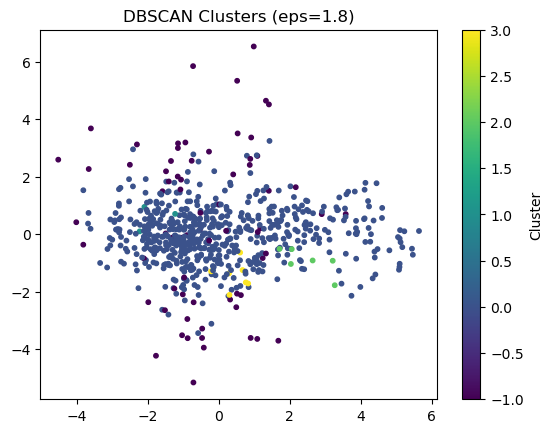

In [113]:
# Reduce data to 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_yeo_df)

# Plot clusters
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='viridis', s=10)
plt.title(f"DBSCAN Clusters (eps={eps_val})")
plt.colorbar(label='Cluster')
plt.show()

In [115]:
#print(features['dbscan_labels'].unique())
print(dbscan_labels)

[ 0 -1  0  0  0  0  0  0 -1 -1  0  0 -1  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0
  0  0  1  0  1  0 -1 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1 -1  0
  0 -1  2  0  3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0
  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0 -1  0  0  0  0 -1  0  0  0 -1
  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0 -1

# Explore Results

In [117]:
votecensus_2020_clustered['kmeans_labels'] = kmeans_labels
votecensus_2020_clustered['dbscan_labels'] = dbscan_labels
votecensus_2020_clustered.head()

,unique_id,year,state_po,county_name,votemargin_DR,proportion_explained_by_DR,delta_2012_16,delta_2016_20,abs_delta_2012_16,abs_delta_2016_20,margin_2012,margin_2016,margin_2020,DP2_education_bachelormin_PE,DP2_marital_male_nevermarried_PE,DP2_foreign_born_PE,DP3_employment_unemp_PE,DP3_median_income_norm,kmeans_labels,dbscan_labels
0,2020_01019,2020,AL,CHEROKEE,-72.8,99.2,-14.0,-3.8,14.0,3.8,-55.0,-69.0,-72.8,12.9,23.1,1.9,2.0,16.2,1,0
1,2020_01037,2020,AL,COOSA,-33.5,99.1,-14.2,-3.0,14.2,3.0,-16.3,-30.4,-33.5,11.6,33.9,0.5,1.2,17.0,8,-1
2,2020_01059,2020,AL,FRANKLIN,-65.9,99.1,-19.9,-5.5,19.9,5.5,-40.5,-60.4,-65.9,15.0,32.1,9.1,2.7,15.1,5,0
3,2020_01071,2020,AL,JACKSON,-67.5,98.9,-20.1,-5.5,20.1,5.5,-41.9,-61.9,-67.5,16.2,25.4,1.5,2.6,16.3,1,0
4,2020_01075,2020,AL,LAMAR,-72.2,99.4,-15.5,-3.5,15.5,3.5,-53.2,-68.7,-72.2,11.3,25.0,0.9,2.6,16.3,1,0


In [125]:
votecensus_2020_clustered_slice = votecensus_2020_clustered[votecensus_2020_clustered.dbscan_labels > 0] # removes label 0 and label -1
votecensus_2020_clustered_slice.shape

(16, 20)

In [127]:
votecensus_2020_clustered_slice.head(51).sort_values(['dbscan_labels', 'kmeans_labels'])

,unique_id,year,state_po,county_name,votemargin_DR,proportion_explained_by_DR,delta_2012_16,delta_2016_20,abs_delta_2012_16,abs_delta_2016_20,margin_2012,margin_2016,margin_2020,DP2_education_bachelormin_PE,DP2_marital_male_nevermarried_PE,DP2_foreign_born_PE,DP3_employment_unemp_PE,DP3_median_income_norm,kmeans_labels,dbscan_labels
50,2020_12013,2020,FL,CALHOUN,-62.3,99.3,-12.2,-6.1,12.2,6.1,-43.9,-56.1,-62.3,9.1,39.9,2.6,1.7,12.6,5,1
52,2020_12029,2020,FL,DIXIE,-66.0,99.5,-16.3,-2.8,16.3,2.8,-46.9,-63.2,-66.0,9.5,31.4,2.7,1.6,15.5,5,1
583,2020_48335,2020,TX,MITCHELL,-68.7,99.5,-12.3,-3.8,12.3,3.8,-52.6,-64.9,-68.7,12.1,45.7,3.5,1.4,18.1,5,1
74,2020_16019,2020,ID,BONNEVILLE,-43.6,96.4,11.6,-3.4,11.6,3.4,-51.8,-40.2,-43.6,30.9,29.0,4.9,2.5,31.4,4,2
592,2020_49005,2020,UT,CACHE,-36.6,93.7,40.8,-9.4,40.8,9.4,-68.1,-27.2,-36.6,38.5,35.8,6.4,2.0,30.6,4,2
593,2020_49011,2020,UT,DAVIS,-27.5,95.1,37.8,-3.4,37.8,3.4,-61.9,-24.2,-27.5,38.2,29.3,5.3,1.8,52.3,4,2
595,2020_49021,2020,UT,IRON,-56.2,95.1,20.6,-4.5,20.6,4.5,-72.2,-51.6,-56.2,28.9,32.4,4.0,3.0,23.8,4,2
602,2020_49045,2020,UT,TOOELE,-38.3,95.1,20.4,-8.1,20.4,8.1,-50.6,-30.2,-38.3,23.1,30.8,4.1,3.6,43.6,4,2
604,2020_49049,2020,UT,UTAH,-41.1,94.6,42.0,-4.5,42.0,4.5,-78.6,-36.5,-41.1,41.1,34.7,7.3,2.6,43.9,4,2
76,2020_16031,2020,ID,CASSIA,-66.9,97.3,12.1,-6.8,12.1,6.8,-72.1,-60.1,-66.9,19.4,27.3,9.0,2.1,24.0,4,3


In [129]:
votecensus_2020_clustered_slice.to_csv('../data/results/votecensus_2020_clustered_slice_largemargins.csv', index=False)